In [72]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from collections import Counter


In [73]:
# Cargar archivos de datos
stockprices = pd.read_csv('../data/processed/stock_prices.csv')
financialnews = pd.read_csv('../data/processed/financial_news_clean.csv')

In [74]:
stockprices

,date,ticker,open_price,close_price,high_price,low_price,volume,newsCount,newsStockPrice
0,2022-01-03 09:00:00,AAPL,178.26,178.08,178.34,177.76,60937,1,178.08
1,2022-01-03 10:00:00,AAPL,178.08,178.17,178.22,177.99,45629,1,178.17
2,2022-01-03 11:00:00,AAPL,178.17,178.45,178.46,178.16,39121,1,178.45
3,2022-01-03 12:00:00,AAPL,178.46,178.22,178.50,178.09,103317,1,178.22
4,2022-01-03 13:00:00,AAPL,178.37,177.65,178.48,177.57,440026,1,177.65
...,...,...,...,...,...,...,...,...,...
76782,2024-08-19 17:00:00,MICS,0.55,0.55,0.55,0.53,11668,0,0.00
76783,2024-08-19 18:00:00,MICS,0.55,0.55,0.59,0.54,35023,0,0.00
76784,2024-08-19 19:00:00,MICS,0.56,0.54,0.58,0.54,3878,0,0.00
76785,2024-08-19 20:00:00,MICS,0.54,0.53,0.54,0.53,700,0,0.00


In [75]:
financialnews['published_year'] = pd.to_datetime(financialnews['published_date']).dt.year

In [76]:
financialnewsm = financialnews.query('ticker in ("AAPL", "GPRO") and published_year >= 2022')

In [77]:
financialnewsm.ticker.value_counts()

ticker
AAPL    12782
GPRO      205
Name: count, dtype: int64

In [78]:
# Cargar modelo
model = joblib.load('../models/model_glove.pkl')

In [ ]:
# Tokenizar y convertir a secuencia
vocab_size = 5000
max_length = 20
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(financialnewsm['cleaned_text'])

# Predecir
financialnewsm['sentiment'] = financialnewsm['cleaned_text'].apply(lambda x: np.argmax(model.predict(pad_sequences(tokenizer.texts_to_sequences([x]), maxlen=max_length, padding='post', truncating='post')), axis=1)[0])

In [80]:
financialnewsfinal = financialnewsm[['published_date', 'ticker', 'cleaned_text', 'sentiment']].copy()
financialnewsfinal['published_date'] = pd.to_datetime(financialnewsfinal['published_date'])
financialnewsfinal['published_date'] = financialnewsfinal['published_date'].dt.date
newsdia = financialnewsfinal.groupby(['published_date', 'ticker']).agg({'sentiment': 'mean'}).reset_index()

newsdia['sentiment_label'] = newsdia['sentiment'].apply(lambda x: 'positive' if x > 1 else 'negative' if x < 0.5 else 'neutral')

In [81]:
newsdia

,published_date,ticker,sentiment,sentiment_label
0,2022-01-03,AAPL,1.357143,positive
1,2022-01-04,AAPL,1.222222,positive
2,2022-01-05,AAPL,1.733333,positive
3,2022-01-06,AAPL,0.941176,neutral
4,2022-01-06,GPRO,1.000000,neutral
...,...,...,...,...
1100,2024-08-14,AAPL,1.250000,positive
1101,2024-08-15,AAPL,0.800000,neutral
1102,2024-08-16,AAPL,2.000000,positive
1103,2024-08-17,AAPL,1.333333,positive


In [82]:
stockprices['date'] = pd.to_datetime(stockprices['date'])
stockprices['year'] = stockprices['date'].dt.year
stockprices['date'] = stockprices['date'].dt.date

stockpricesfinal = stockprices.query('ticker in ("AAPL", "GPRO") and year >= 2022').copy()
stockpricesdia = stockpricesfinal.groupby(['date', 'ticker']).agg(
    precio_cierra=('close_price', 'last'),
    retorno = ('close_price', lambda x: x.iloc[-1] / x.iloc[0] - 1),
    retornoLog=('close_price', lambda x: np.log(x.iloc[-1] / x.iloc[0]))
).reset_index()

In [83]:
stockpricesdia

,date,ticker,precio_cierra,retorno,retornoLog
0,2022-01-03,AAPL,181.91,0.021507,0.021279
1,2022-01-03,GPRO,10.66,0.025000,0.024693
2,2022-01-04,AAPL,179.35,-0.014506,-0.014613
3,2022-01-04,GPRO,10.82,0.000000,0.000000
4,2022-01-05,AAPL,175.06,-0.023811,-0.024099
...,...,...,...,...,...
1388,2024-08-15,GPRO,1.23,0.060345,0.058594
1389,2024-08-16,AAPL,225.95,0.002885,0.002881
1390,2024-08-16,GPRO,1.25,0.008065,0.008032
1391,2024-08-19,AAPL,225.70,0.000443,0.000443


In [84]:
# merge data
finaldata = pd.merge(stockpricesdia, newsdia, left_on=['date', 'ticker'], right_on=['published_date', 'ticker'], how='left')

In [85]:
df_aapl = finaldata.query('ticker == "AAPL"').copy()
df_gpro = finaldata.query('ticker == "GPRO"').copy()

df_aapl['sentiment'] = df_aapl['sentiment'].ffill()
df_gpro['sentiment'] = df_gpro['sentiment'].ffill()
df_aapl['sentiment_label'] = df_aapl['sentiment_label'].ffill()
df_gpro['sentiment_label'] = df_gpro['sentiment_label'].ffill()

df_diario = pd.concat([df_aapl, df_gpro])
df_diario

,date,ticker,precio_cierra,retorno,retornoLog,published_date,sentiment,sentiment_label
0,2022-01-03,AAPL,181.91,0.021507,0.021279,2022-01-03,1.357143,positive
2,2022-01-04,AAPL,179.35,-0.014506,-0.014613,2022-01-04,1.222222,positive
4,2022-01-05,AAPL,175.06,-0.023811,-0.024099,2022-01-05,1.733333,positive
6,2022-01-06,AAPL,172.60,-0.014109,-0.014209,2022-01-06,0.941176,neutral
8,2022-01-07,AAPL,172.01,-0.005147,-0.005161,2022-01-07,1.347826,positive
...,...,...,...,...,...,...,...,...
1384,2024-08-13,GPRO,1.30,0.083333,0.080043,NaN,2.000000,positive
1386,2024-08-14,GPRO,1.19,-0.084615,-0.088411,NaN,2.000000,positive
1388,2024-08-15,GPRO,1.23,0.060345,0.058594,NaN,2.000000,positive
1390,2024-08-16,GPRO,1.25,0.008065,0.008032,NaN,2.000000,positive


<Axes: xlabel='sentiment_label'>

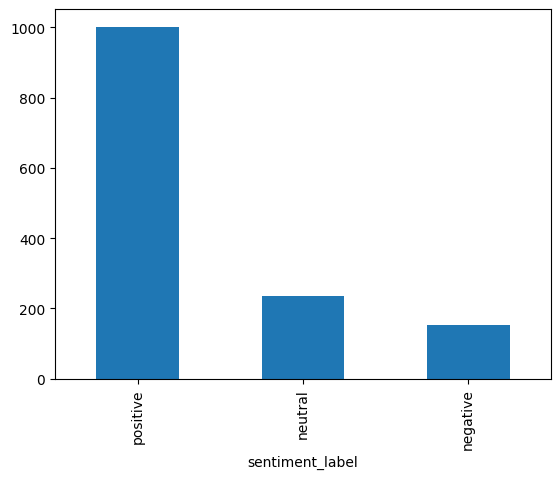

In [86]:
df_diario.sentiment_label.value_counts().plot(kind='bar')

In [87]:
df_diario["retorno_siguiente"] = df_diario["retorno"].shift(-1)
df_diario["retornoLog_siguiente"] = df_diario["retornoLog"].shift(-1)
df_diario["tendencia"] = np.where(df_diario["retornoLog_siguiente"] > 0.002, 1, 
                                  np.where(df_diario["retornoLog_siguiente"] < -0.002, -1, 0))



<Axes: xlabel='tendencia'>

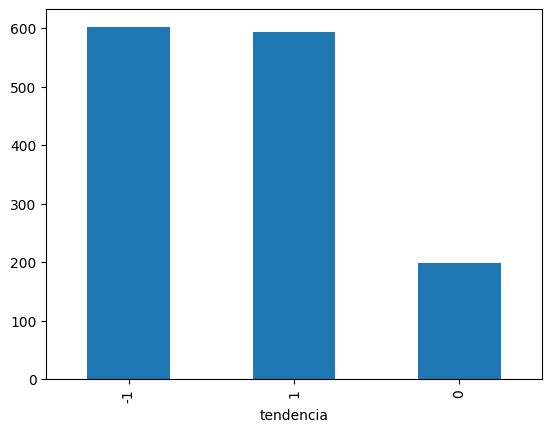

In [88]:
df_diario.tendencia.value_counts().plot(kind='bar')

In [89]:
df_model = df_diario.copy()
df_model.dropna(inplace=True)

In [90]:
df_diario.ticker.value_counts()

ticker
AAPL    706
GPRO    687
Name: count, dtype: int64

In [100]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Variables
X = df_model[["sentiment"]]
y = df_model["tendencia"]

# Dividir datos: se usa 80% para entrenamiento y 20% para prueba sin mezclar (manteniendo el orden temporal)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Pipeline con escalado y clasificador
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Parámetros a optimizar
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10]
}

# Búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)

# Uso del mejor modelo encontrado
best_model = grid_search.best_estimator_
y_pred_clf = best_model.predict(X_test)

# Evaluación
print(f"Accuracy: {accuracy_score(y_test, y_pred_clf):.4f}")
print(classification_report(y_test, y_pred_clf))

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

Mejores parámetros: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Accuracy: 0.4762
              precision    recall  f1-score   support

          -1       0.58      0.50      0.54        82
           0       0.00      0.00      0.00        22
           1       0.43      0.61      0.51        64

    accuracy                           0.48       168
   macro avg       0.34      0.37      0.35       168
weighted avg       0.45      0.48      0.45       168



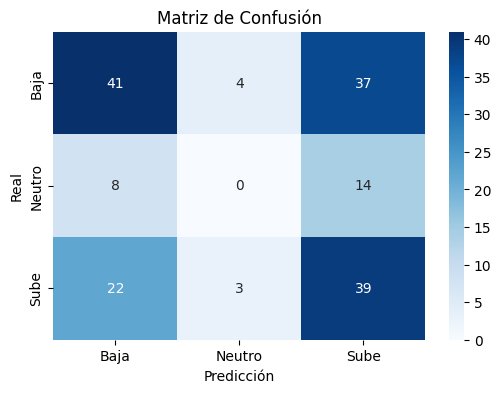

Accuracy: 0.47619047619047616


In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_clf)

# Graficar con Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Baja", "Neutro", "Sube"], yticklabels=["Baja", "Neutro", "Sube"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred_clf))


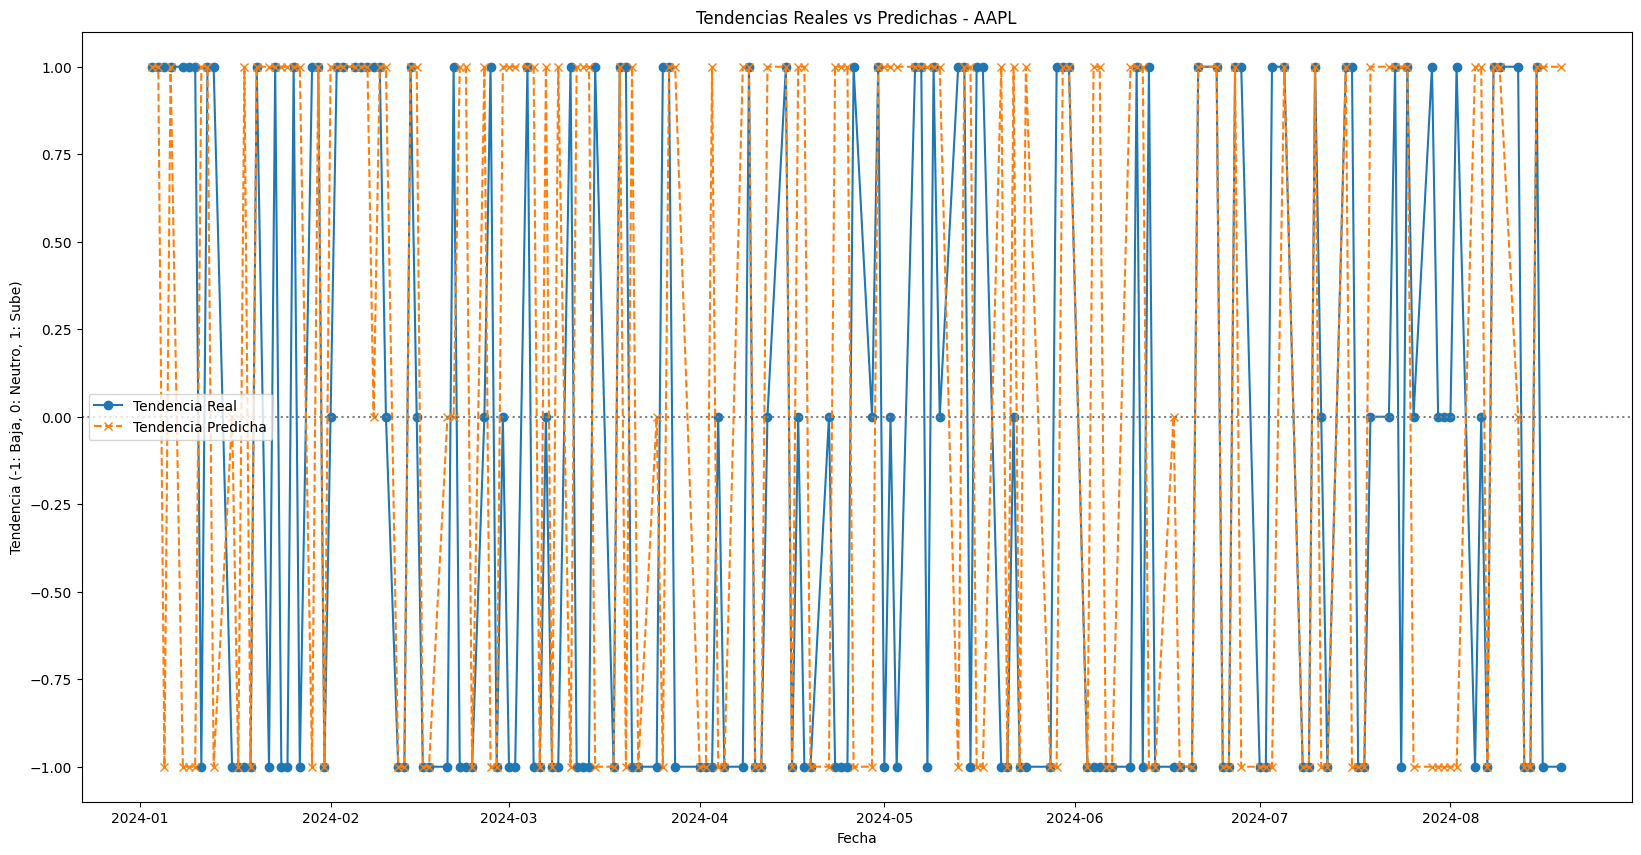

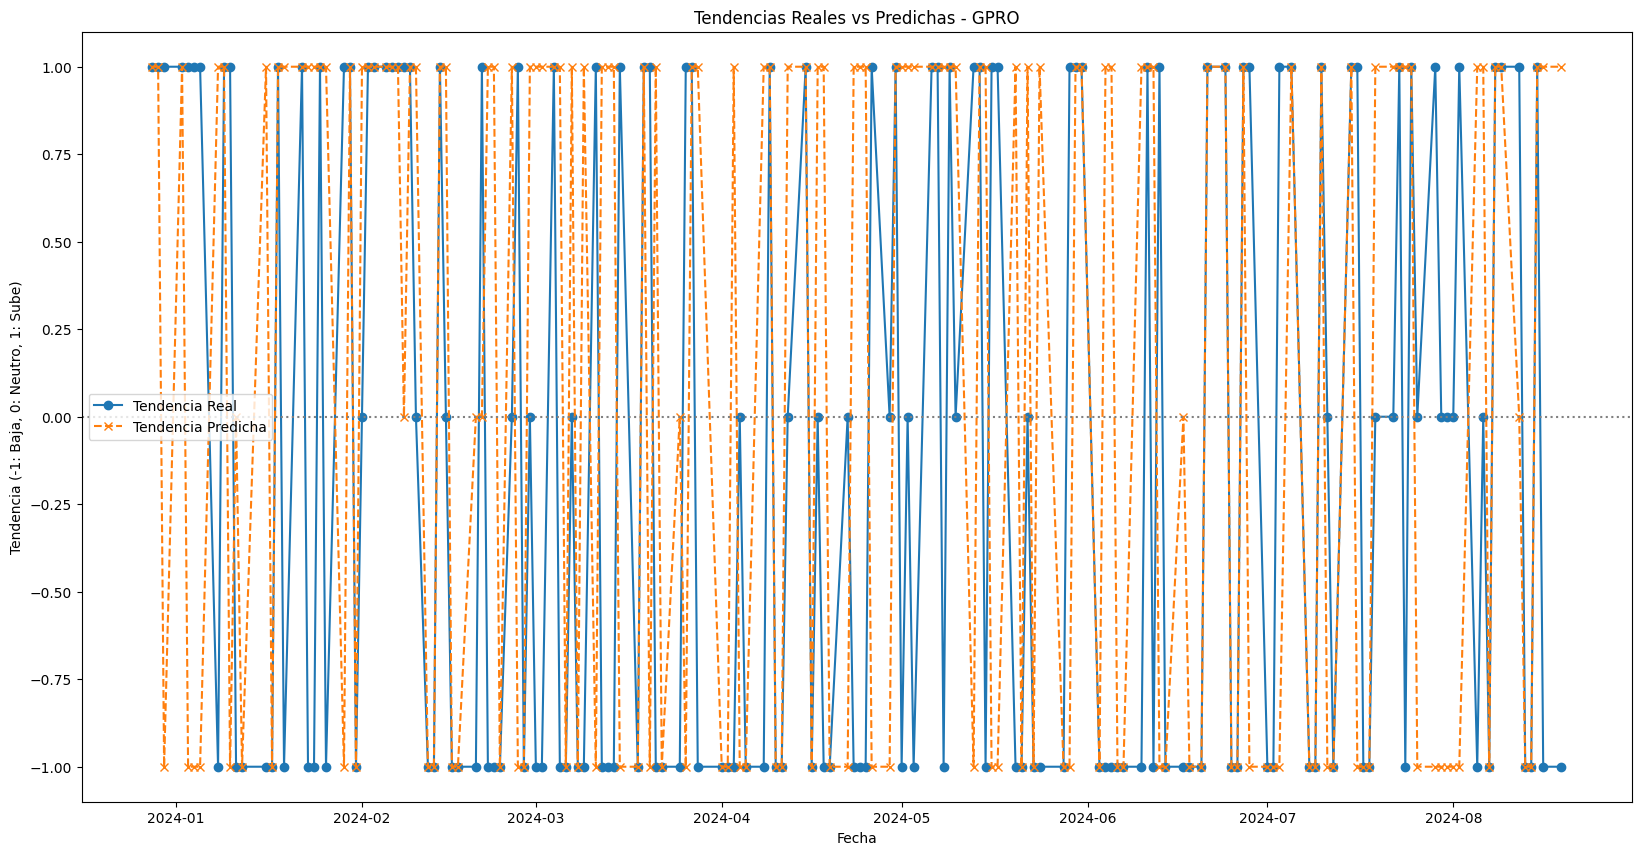

In [102]:
for ticker in df_diario["ticker"].unique():
    df_graph = df_diario.query(f"ticker == '{ticker}'")
    plt.figure(figsize=(20, 10))
    plt.plot(df_graph["date"].iloc[-len(y_test):], y_test, label="Tendencia Real", marker='o')
    plt.plot(df_graph["date"].iloc[-len(y_test):], y_pred_clf, label="Tendencia Predicha", linestyle="dashed", marker='x')
    plt.axhline(0, color='gray', linestyle='dotted')  # Línea para tendencia neutra
    plt.xlabel("Fecha")
    plt.ylabel("Tendencia (-1: Baja, 0: Neutro, 1: Sube)")
    plt.legend()
    plt.title(f"Tendencias Reales vs Predichas - {ticker}")
    plt.show()